# <center>Classification of audio files by sex using a neural network

In [1]:
import os
import time
import librosa
import IPython
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.io import wavfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings('ignore')

**Check one of the files.**

In [2]:
amplitudes, sample_rate = librosa.load('train/00a6d37bad8722aa683284a16b054180.wav')
print(f"{len(amplitudes)} points, {len(amplitudes) / sample_rate} sec, sr {sample_rate}")

151940 points, 6.890702947845805 sec, sr 22050


In [3]:
IPython.display.Audio('train/00a6d37bad8722aa683284a16b054180.wav')

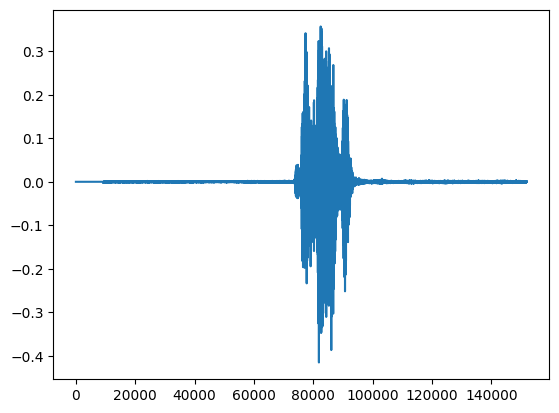

In [4]:
plt.plot(amplitudes);

**Cut off the silence from the beginning and end of each audio track and save it to a new directory.**

In [5]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

if not os.path.exists('train_clean/'):
    os.makedirs('train_clean/')

for _, _, filenames in os.walk('train/'):
    for filename in tqdm(filenames[:-1]):
        amplitude,_ = librosa.load('train/' + filename, sr=16000)
        mask = envelope(amplitude, 16000, 0.005)
        wavfile.write(filename='train_clean/'+filename, rate=16000, data=amplitude[mask])

100%|██████████| 13936/13936 [02:49<00:00, 82.10it/s]


**Let's see how the old file has changed.**

In [6]:
amplitudes, sample_rate = librosa.load('train_clean/00a6d37bad8722aa683284a16b054180.wav', sr=16000)
print(f"{len(amplitudes)} points, {len(amplitudes) / sample_rate} sec, sr {sample_rate}")

14516 points, 0.90725 sec, sr 16000


In [7]:
IPython.display.Audio('train_clean/00a6d37bad8722aa683284a16b054180.wav')

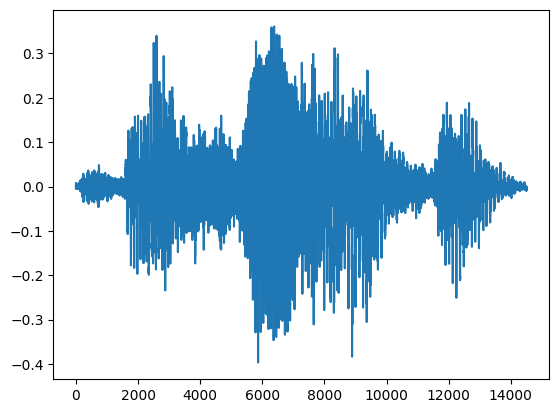

In [8]:
plt.plot(amplitudes);

**A class for loading data and generating the necessary datasets.**

In [9]:
class my_dataloader:
    def __init__(self, data_path='train_clean/', train_mode=True):
        self.X = []
        self.y = []
        self.t = 0
        with open('train/targets.tsv') as f:
            self.id_sex_dict = dict([(tmp.split('\t')[0], tmp.split('\t')[1][0]) for tmp in f.readlines()])
            
            for _, _, filenames in os.walk('clean/'):
                for filename in filenames[:]:
                    amplitude,_ = librosa.load(data_path + filename, sr=16000)
                    self.X.append(amplitude)
                    self.y.append(self.id_sex_dict.get(filename.replace('.wav','')))
            
            self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(self.X, self.y, 
                                                                                    train_size=0.67, 
                                                                                    random_state=0)
            self.X_valid, self.X_test, self.y_valid, self.y_test = train_test_split(self.X_valid, self.y_valid, 
                                                                                    train_size=0.5, 
                                                                                    random_state=0)
        self.trainset = self.create_dataset('train') 
        self.validset = self.create_dataset('valid') 
        self.testset = self.create_dataset('test')

    def return_sex (self, id): 
        return self.id_sex_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset
                  
    def return_test(self):
        return self.testset
    
    def create_dataset(self, mode):
        X,y = [],[]
        if mode == 'train':
            X = self.X_train
            y = self.y_train
        elif mode == 'valid':
            X = self.X_valid
            y = self.y_valid
        else:
            X = self.X_test
            y = self.y_test        
        
        features,targets = [],[]
        for i in tqdm(range(len(X))):
            s = self.preprocess_sample(np.array(X[i], dtype=float))
            features.append(s)
            targets.append(y[i])
                
        dataset = TensorDataset(torch.Tensor(features), torch.Tensor(np.array(targets, dtype=int)))
        return dataset

    # Extract features from audiofile amplitudes
    def preprocess_sample(self, amplitudes, sample_rate=16000):
        mfccs = np.mean(librosa.feature.mfcc(y=amplitudes, sr=sample_rate, n_mfcc=40).T,axis=0)
        stft = np.abs(librosa.stft(amplitudes))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=amplitudes, sr=sample_rate).T,axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(amplitudes), sr=sample_rate).T,axis=0)
        
        return np.concatenate([mfccs, chroma, mel, contrast, tonnetz])

**Neural network architecture.**

In [10]:
class AudioModel(nn.Module):
    def __init__(self):
        super(AudioModel, self).__init__()

        self.model = nn.Sequential(
            nn.BatchNorm1d(193),
            nn.Linear(193, 180),
            nn.ReLU(),
            nn.BatchNorm1d(180),
            nn.Linear(180, 150),
            nn.ReLU(),
            nn.BatchNorm1d(150),
            nn.Linear(150, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 1)  
        )


    def forward(self, x):
        x = self.model(x)
        x = torch.sigmoid(x)
        return x

**Set device to cuda if available**

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using {device} node')

using cuda node


In [12]:
model = AudioModel()
model = model.to(device)

**Initialize my_dataloader and get three datasets**

In [13]:
_my_dataloader = my_dataloader()
train_data, valid_data, test_data = _my_dataloader.return_data()

100%|██████████| 2300/2300 [03:34<00:00, 10.73it/s]


**Train model**

In [14]:
def train(epochs=30, batch_size=64, lr=0.001, gamma=0.8):
    best_acc = 0
    model.train()
    train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(valid_data, batch_size=batch_size, shuffle=True) 
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    criterion = F.binary_cross_entropy
    
    for epoch in range(epochs):
        for step, (X, y) in enumerate(train_dl):
            step_time = time.time()
            optimizer.zero_grad()
            out = model(X.to(device))
            loss = criterion(out.squeeze(), y.to(device))
            loss.backward()
            optimizer.step()
            print("Epoch: [{}/{}] step: [{}/{}] time: {:.3f}s, loss: {:.7f} ".format(
                epoch, epochs, step, len(train_data)//batch_size, time.time() - step_time, float(loss)))
        scheduler.step()

        model.eval()
        
        gout = []
        gtarget = []
        for X,y in val_dl:
            out = model(X.to(device))
            out, target = out.cpu().detach().numpy(), y.cpu().detach().numpy()
            out = [1. if tmp > 0.5 else 0 for tmp in out]
            gout += out
            gtarget += y
            
        acc = accuracy_score(gout, gtarget)
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), 'model_weights.pth')
            
        print(f"accuracy_score: {acc}")
        
        model.train()
    print('Best accuracy_score:',best_acc)
    model.load_state_dict(torch.load('model_weights.pth'))

In [15]:
train()

Epoch: [0/30] step: [0/145] time: 0.175s, loss: 0.7463378 
Epoch: [0/30] step: [1/145] time: 0.004s, loss: 0.6918635 
Epoch: [0/30] step: [2/145] time: 0.003s, loss: 0.7094030 
Epoch: [0/30] step: [3/145] time: 0.003s, loss: 0.6396365 
Epoch: [0/30] step: [4/145] time: 0.003s, loss: 0.6130832 
Epoch: [0/30] step: [5/145] time: 0.007s, loss: 0.5767041 
Epoch: [0/30] step: [6/145] time: 0.003s, loss: 0.5565785 
Epoch: [0/30] step: [7/145] time: 0.004s, loss: 0.5617886 
Epoch: [0/30] step: [8/145] time: 0.005s, loss: 0.5544181 
Epoch: [0/30] step: [9/145] time: 0.003s, loss: 0.5233664 
Epoch: [0/30] step: [10/145] time: 0.003s, loss: 0.5262773 
Epoch: [0/30] step: [11/145] time: 0.007s, loss: 0.5284913 
Epoch: [0/30] step: [12/145] time: 0.003s, loss: 0.4461111 
Epoch: [0/30] step: [13/145] time: 0.003s, loss: 0.4487095 
Epoch: [0/30] step: [14/145] time: 0.006s, loss: 0.4188404 
Epoch: [0/30] step: [15/145] time: 0.003s, loss: 0.3888569 
Epoch: [0/30] step: [16/145] time: 0.002s, loss: 0

**Test accuracy on test_dataset**

In [16]:
test_dl = DataLoader(test_data, batch_size=64)
gtarget = []
gout = []

model.eval()
for X,y in test_dl:
    out = model(X.to(device))
    out, target = out.cpu().detach().numpy(), y.cpu().detach().numpy()
    out = [1. if tmp > 0.5 else 0 for tmp in out]
    gout += out
    gtarget += y

print(f"accuracy_score: {accuracy_score(gout, gtarget)}")

accuracy_score: 0.9930434782608696


**Function to test by yourself**

In [17]:
model.eval()
def predict(wavfile):
    waveform, _ = librosa.load(wavfile, sr=16000)
    
    input = _my_dataloader.preprocess_sample(waveform)
    input = torch.tensor(input)[None,:].float().to(device)
    
    with torch.no_grad():
        out = model(input)
        out = out.cpu().detach().numpy()
    print(out)
    out = 'female' if out > 0.5 else 'male'
    return out

In [18]:
IPython.display.Audio('clean/11622347865947d971e527e3d971f2f9.wav')

In [19]:
predict('clean/11622347865947d971e527e3d971f2f9.wav')

[[0.99959975]]


'female'

**Processing audio files without target**

In [20]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

if not os.path.exists('test_clean/'):
    os.makedirs('test_clean/')

for _, _, filenames in os.walk('test/'):
    for filename in tqdm(filenames[:]):
        amplitude,_ = librosa.load('test/' + filename, sr=16000)
        mask = envelope(amplitude, 16000, 0.005)
        wavfile.write(filename='test_clean/'+filename, rate=16000, data=amplitude[mask])

100%|██████████| 3413/3413 [00:43<00:00, 78.36it/s]


In [21]:
real_testdata = []
test_filenames = []
for _, _, filenames in os.walk('test_clean/'):
    test_filenames = filenames
    for filename in filenames[:]:
        amplitude,_ = librosa.load('test_clean/' + filename, sr=16000)
        real_testdata.append(amplitude)

In [22]:
features = []
for i in tqdm(range(len(real_testdata))):
    s = _my_dataloader.preprocess_sample(real_testdata[i])
    features.append(s)

100%|██████████| 3413/3413 [05:12<00:00, 10.93it/s]


**Predict target and write it in to the answers.tsv**

In [30]:
gout = []

with open('answers.tsv', 'w') as file:
    model.eval()
    for i, X in enumerate(features):
        out = model(torch.tensor(X)[None,:].float().to(device))
        out = out.cpu().detach().numpy()
        out = 1 if out > 0.5 else 0 
        file.write(test_filenames[i].replace('.wav', '') + '\t' + str(out) + '\n')